In [1]:
from astropy.io import fits
from astropy.table import Table, vstack
import astropy.units as u
import numpy as np
import os
import sys
import pandas as pd
from pathlib import Path
import h5py

import matplotlib.pyplot as plt

### Read cat & random QSO

In [3]:
path_qso_models = Path('/data2/home2/nguerrav/QSO_simpaqs/QSOs_full_cat/')

In [8]:
catalog = Table.read('/data2/home2/nguerrav/Catalogues/ByCycle_Final_Cat_fobs_qso_templates_with_SNR_golden_label.fits').to_pandas()
catalog.columns

Index(['SWEEP_NAME', 'INDEX_SWEEP', 'BRICKNAME', 'OBJID', 'TYPE', 'RA', 'DEC',
       'EBV', 'SN_MAX', 'PLXSIG', 'PMSIG', 'BAND_LEGACY', 'REFERENCE_BAND',
       'COMBINATION_USE', 'CAL_MAG_BLUE', 'CAL_MAG_GREEN', 'CAL_MAG_RED',
       'MAG', 'CAL_MAG_ERR_BLUE', 'CAL_MAG_ERR_GREEN', 'CAL_MAG_ERR_RED',
       'MAG_ERR', 'MAG_Y', 'MAG_J', 'MAG_H', 'MAG_K', 'MAGERR_Y', 'MAGERR_J',
       'MAGERR_H', 'MAGERR_K', 'MAG_W1', 'MAG_W2', 'MAGERR_W1', 'MAGERR_W2',
       'P_QSO', 'REDSHIFT_ESTIMATE', 'Z1_QSO', 'Z2_QSO', 'P_QSO_Z', 'P_GALAXY',
       'PHOTOZ_GALAXY', 'Z1_GALAXY', 'Z2_GALAXY', 'P_GALAXY_Z', 'P_STAR',
       'RATIO', 'CLASS_SPEC', 'Z_SPEC', 'REDSHIFT_ERROR', 'REDSHIFT_REF', 'l',
       'b', 'pm', 'PMRA', 'PMDEC', 'pmra_error', 'pmdec_error', 'Z_DESI',
       'SPECTYPE_DESI', 'SUBSURVEY', 'EPOCH', 'RESOLUTION', 'CADENCE',
       'TEMPLATE', 'EXTENT_FLAG', 'EXTENT_PARAMETER', 'EXTENT_INDEX',
       'REDDENING', 'TEMPLATE_REDSHIFT', 'DATE_EARLIEST', 'DATE_LATEST',
       'CLASSIFICATIO

In [5]:
random_qso = Table.read(path_qso_models / 'QSO_sim_z0.6_MgIIBlueDeep_0.364m34.7046.fits')
random_qso

LAMBDA,FLUX_DENSITY
Angstrom,erg / (Angstrom s cm2)
float64,float32
3926.04,1.1058494e-15
3926.12,1.105827e-15
3926.2,1.1058069e-15
3926.2799999999997,1.1057868e-15
3926.36,1.1057666e-15
3926.44,1.1057465e-15
3926.52,1.1057262e-15
3926.6,1.1057061e-15


In [15]:
np.array(random_qso['FLUX_DENSITY'][:])

array([1.1058494e-15, 1.1058270e-15, 1.1058069e-15, ..., 2.5957558e-16,
       2.5956875e-16, 2.5956194e-16], dtype='>f4')

### Read absorbers

In [3]:
absorbers_z_05 = h5py.File('/data2/home2/nguerrav/TNG50_spec/spectra_TNG50-1_z0.5_n2000d2-rndfullbox_4MOST-HRS_MgII_combined.hdf5', 'r')
absorbers_z_05.keys()

<KeysViewHDF5 ['EW_MgII_2796', 'EW_MgII_2803', 'flux', 'ray_dir', 'ray_pos', 'ray_total_dl', 'tau_MgII_2796', 'tau_MgII_2803', 'wave']>

In [4]:
absorbers_z_05['EW_MgII_2796'][absorbers_z_05['EW_MgII_2796'][:]>0.0].shape

(2899345,)

## save spectra with absorbers only

In [6]:
absorbers_z_05.keys()

<KeysViewHDF5 ['EW_MgII_2796', 'EW_MgII_2803', 'flux', 'ray_dir', 'ray_pos', 'ray_total_dl', 'tau_MgII_2796', 'tau_MgII_2803', 'wave']>

In [7]:
mask = absorbers_z_05['EW_MgII_2796'][:] > 0.0

In [ ]:
# Create a new HDF5 file with filtered data
with h5py.File('/data2/home2/nguerrav/TNG50_spec/absorbers_spectra_TNG50-1_z0.5_n2000d2-rndfullbox_4MOST-HRS_MgII_combined_filtered.hdf5', 'w') as filtered_file:
    
    # First pass: handle datasets that don't need masking
    for key in absorbers_z_05.keys():
        dataset = absorbers_z_05[key]
        
        # Check first dimension instead of using len()
        if dataset.ndim == 0 or dataset.shape[0] != len(mask):
            # Handle scalar or non-matching datasets
            filtered_file.create_dataset(key, data=dataset[()])
            print(f"Copied {key} (shape: {dataset.shape})")
    
    # Second pass: handle large datasets that need masking
    chunk_size = 10000  # Adjust based on your available RAM
    mask_indices = np.where(mask)[0]  # Get indices where mask is True
    
    for key in absorbers_z_05.keys():
        dataset = absorbers_z_05[key]
        
        if len(dataset) == len(mask):
            print(f"Processing {key} with chunking (original size: {dataset.shape})")
            
            # Create output dataset with filtered size
            filtered_shape = (len(mask_indices),) + dataset.shape[1:]
            filtered_dataset = filtered_file.create_dataset(
                key, 
                shape=filtered_shape, 
                dtype=dataset.dtype,
                chunks=True,  # Enable chunking for better I/O
                compression='gzip'  # Optional: compress to save disk space
            )
            
            # Process in chunks
            output_idx = 0
            for i in range(0, len(mask_indices), chunk_size):
                # Get chunk of indices
                chunk_indices = mask_indices[i:i + chunk_size]
                
                # Read only the rows we need
                chunk_data = dataset[chunk_indices]
                
                # Write to output file
                end_idx = output_idx + len(chunk_data)
                filtered_dataset[output_idx:end_idx] = chunk_data
                output_idx = end_idx
                
                print(f"  Processed chunk {i//chunk_size + 1}, rows {i+1}-{min(i+chunk_size, len(mask_indices))}")

Copied ray_dir (shape: (3,))
Copied ray_total_dl (shape: ())
Copied wave (shape: (35800,))
Processing EW_MgII_2796 with chunking (original size: (4000000,))
  Processed chunk 1, rows 1-10000
  Processed chunk 2, rows 10001-20000
  Processed chunk 3, rows 20001-30000
  Processed chunk 4, rows 30001-40000
  Processed chunk 5, rows 40001-50000
  Processed chunk 6, rows 50001-60000
  Processed chunk 7, rows 60001-70000
  Processed chunk 8, rows 70001-80000
  Processed chunk 9, rows 80001-90000
  Processed chunk 10, rows 90001-100000
  Processed chunk 11, rows 100001-110000
  Processed chunk 12, rows 110001-120000
  Processed chunk 13, rows 120001-130000
  Processed chunk 14, rows 130001-140000
  Processed chunk 15, rows 140001-150000
  Processed chunk 16, rows 150001-160000
  Processed chunk 17, rows 160001-170000
  Processed chunk 18, rows 170001-180000
  Processed chunk 19, rows 180001-190000
  Processed chunk 20, rows 190001-200000
  Processed chunk 21, rows 200001-210000
  Processed ch

## plot distributions

(array([3.987455e+06, 1.007300e+04, 1.820000e+03, 4.400000e+02,
        1.180000e+02, 5.400000e+01, 2.100000e+01, 9.000000e+00,
        8.000000e+00, 2.000000e+00]),
 array([0.        , 0.96346414, 1.92692828, 2.89039254, 3.85385656,
        4.81732082, 5.78078508, 6.74424934, 7.70771313, 8.67117786,
        9.63464165]),
 <BarContainer object of 10 artists>)

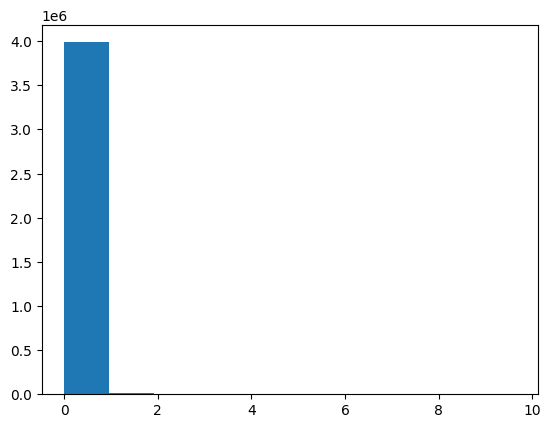

In [6]:
plt.hist(absorbers_z_05['EW_MgII_2796'][:])

### Wavelength grids in TNG & simqso

In [ ]:
# np.unique(np.subtract(np.asarray(random_qso['LAMBDA'][:35800]), absorbers_z_05['wave'][:]))

NameError: name 'random_qso' is not defined

In [11]:
catalog.shape

(1361483, 86)